<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/<'folder'/'notebookname'>.ipynb" target="_blank" rel="noopener noreferrer"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

<a id="intro"></a>
# BCIs and Ghost Music


http://hplgit.github.io/primer.html/doc/pub/diffeq/._diffeq-solarized002.html


maybe: https://web.mit.edu/music21/doc/index.html ? (see example implementation here https://www.datacamp.com/tutorial/using-tensorflow-to-compose-music)



<!-- <figure align="center">
<img src='https://github.com/neurologic/Neurophysiology-Lab/blob/main/images/example-eods_Kramer.jpeg?raw=True' width="300" alt='eod e-field' align="center"/>
<figcaption align = "center"><b>Electric organ discharge waveform</b> and sex, in three snoutfish species of southern Africa. All electric organ discharges represented as voltage over time, recorded in the field immediately after capture. Same time bar for all. (a) Sexual dimorphism in Marcusenius altisambesi with two distinct waveforms. (b) Sex difference of only a statistical nature in Petrocephalus catostoma (Upper Zambezi form) with, in most males, a stronger second positive phase than in females, such as shown here. (c) Petrocephalus wesselsi (Sabie River, South Africa) with no difference between the sexes. P. wesselsi was recognized as distinct from P. catostoma only recently.
</figcaption>
</figure> -->

<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/<'folder'/'notebookname'>.ipynb" target="_blank" rel="noopener noreferrer">Link to Other Notebooks (colab link)</a>   


<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Part I. ](#one)
- Time series analyses:
    - [Part II. ](#two)
    - [Part III. ](#three)
    - [Part IV. ](#four)
- [Part V. ](#five)

<a id="setup"></a>
# Setup

In [ ]:
#@title {display-mode: "form"}

Import and define functions

In [19]:
#@title {display-mode: "form"}

#@markdown Run this code cell to import packages and define functions 
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage
from scipy.signal import hilbert,medfilt,resample, find_peaks
import seaborn as sns
from datetime import datetime,timezone,timedelta

import matplotlib.pyplot as plt
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()


from scipy.io.wavfile import write

# Defining the creation of a note
def note(frequency, length, amplitude=1, sample_rate=44100):
    time_points = np.linspace(0, length, int(length*sample_rate))
    data = np.sin(2*np.pi*frequency*time_points)
    data = amplitude*data
    # add ramp to onset and offset of note to avoid clicks
    return data


print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Task completed at 2022-05-06 17:14:10.009142-05:00


Mount Google Drive

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

In [ ]:
#@title {display-mode: "form"}

#@markdown Specify the file path 
#@markdown to your recorded data on Drive (find the filepath in the colab file manager:

filepath = "full filepath goes here"  #@param 

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = NaN #@param
number_channels = NaN #@param

downsample = False #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %dur)

fs = 1/sampling_rate
if downsample:
    newfs = 2500 #downsample emg data
    chunksize = int(sampling_rate/newfs)
    data = data[0::chunksize,:]
    fs = np.shape(data)[0]/dur

time = np.linspace(0,np.shape(data)[0]/fs,np.shape(data)[0])


print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

print('Now be a bit patient while it plots.')
fig = go.Figure()
fig.add_trace(go.Scatter(x = time, y = data,line_color='black',name='emg0'))
fig.update_layout(xaxis_title="time(seconds)", yaxis_title='amplitude',width=800, height=500)

<a id="one"></a>
# Part I.

[toc](#toc)

How do we generate a melody mathematically in a computer program? With the note function we can generate a note with a certain amplitude, frequency, and duration. The note is represented as an array. Putting sound arrays for different notes after each other will make up a melody. If we have several sound arrays data1, data2, data3, …, we can make a new array consisting of the elements in the first array followed by the elements of the next array followed by the elements in the next array and so forth:

data = numpy.concatenate((data1, data2, data3, ...))
The frequency of a note that is h half tones up from a base frequency f is given by f2h/12. With the tone A at 440 Hz, we can define notes and the corresponding frequencies as

In [21]:
sample_rate=44100
base_freq = 440.0
notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E',
         'F', 'F#', 'G', 'G#']
notes2freq = {notes[i]: base_freq*2**(i/12.0)
              for i in range(len(notes))}

With the notes to frequency mapping a melody can be made as a series of notes with specified duration:

In [57]:
l = .2  # basic duration unit
tones = [('E', 3*l), ('D', l), ('C#', 2*l), ('B', 2*l), ('A', 2*l),
         ('B', 2*l), ('C#', 2*l), ('D', 2*l), ('E', 3*l),
         ('F#', l), ('E', 2*l), ('D', 2*l), ('C#', 4*l)]

samples = []
for tone, duration in tones :
    s = note(notes2freq[tone], duration)
    samples.append(s)

data = np.concatenate(samples)
data *= 15 # The max amplitude from the resource I used is WAY too loud... 2**15-1 # max_amplitude = 2**15 - 1
# scitools.sound.write(data, "melody.wav")

In [59]:
write('test.wav', sample_rate, data)

Pick a set of notes to associate with each PC. For example, for 2 PCS: E and D. 

In [78]:
l = 1  # basic duration unit should equal the frequency with which you query the activity in EMG space
tones = [('E', l), ('D', l)]

Calculate the PCA space and rename each PC by its tone
> Can either determine PC:note association by most dominant to least, or can select from a list which PC should be associated with each note

In [ ]:
# PCA analysis of EMG data

# rename certain PCs to notes

Create music from the PC space

In [78]:
# For each time step, multiply each note by the PC amplitude
# Might need to adjust the scaling so that the differences are more clear?


# filter the PC dataframe for columns in "tones" list

# bin PC dataframe by time chunks (or rolling average?)
# for each time chunk, get a wav sum of all tones weighted by their PC amplitude

wav = []
for t in num_timebins:
    samples = []
    for tone, duration in tones :

        # get the amplitude
        s = note(notes2freq[tone], duration, amplitude)
        samples.append(s)

    samples = np.asarray(samples)
    wav.append(samples)
    
wav = np.concatenate(wav) # concatenate all of the time bins together to produce result. 

# normalize wav to max amplitude
wav = np.sum(wav,0)/np.max(np.sum(wav,0))

# then multiply by scaling factor to make audible for wave write
audio_scaling = 1
wav *= audio_scaling


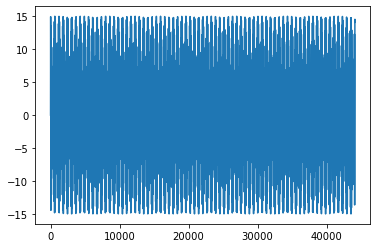

In [84]:
# plot data to look at it before making wav. 
# make sure it is within reasonable audio range (for mac mini... -1 to 1 is fine!)
plt.plot(data)

write('test.wav', sample_rate, data)

<font color = 'green'><b>Figure out how to smoothly vary from one note to the next without amplitude modulation so that can have higher temporal resolution</b></font>

<a id="two"></a>
# Part II.

[toc](#toc)

<a id="three"></a>
# Part III.

[toc](#toc)

<a id="four"></a>
# Part IV.

[toc](#toc)

<a id="five"></a>
# Part V.

[toc](#toc)

<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.

<a id="setup"></a>

<a id="one"></a>

<a id="two"></a>

<a id="three"></a>

<a id="four"></a>